In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# -------------------------------
# PART 1: Data Loading & Exploration
# -------------------------------

df = pd.read_csv(r"C:\Users\LENOVO\python datascience basics (hydrabad ds)\ASSIGNMENT DATA SCIENCE\Timeseries\exchange_rate.csv", parse_dates=[0])
df.columns = ["Date", "USD_AUD"]
df.set_index("Date", inplace=True)

print(df.head())

                  USD_AUD
Date                     
01-01-1990 00:00   0.7855
02-01-1990 00:00   0.7818
03-01-1990 00:00   0.7867
04-01-1990 00:00   0.7860
05-01-1990 00:00   0.7849


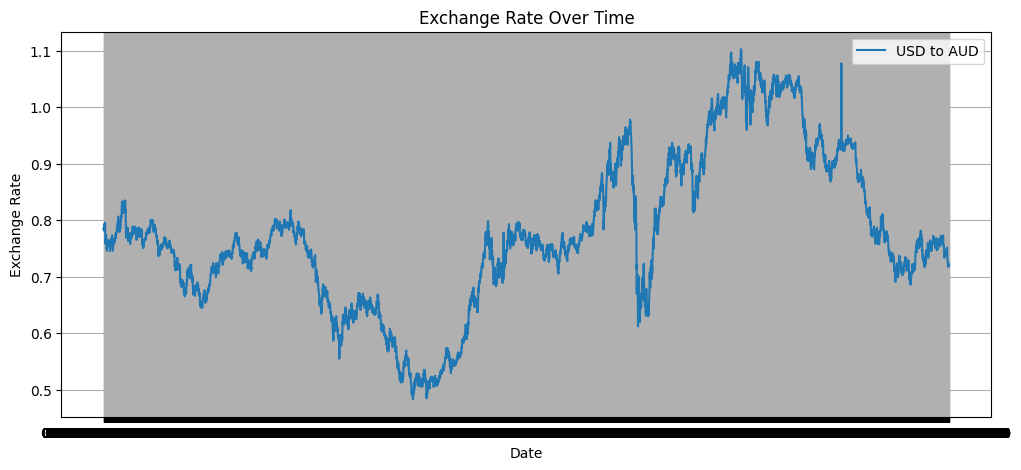

In [3]:
# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(df["USD_AUD"], label="USD to AUD")
plt.title("Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid()
plt.show()

In [4]:
# Check missing values
print("Missing values:\n", df.isnull().sum())

# Fill missing using forward-fill
df.fillna(method='ffill', inplace=True)

Missing values:
 USD_AUD    0
dtype: int64


In [5]:
# -------------------------------
# PART 2: ARIMA Model
# -------------------------------

# Stationarity check
result = adfuller(df["USD_AUD"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.6649941807381414
p-value: 0.4492327353597959


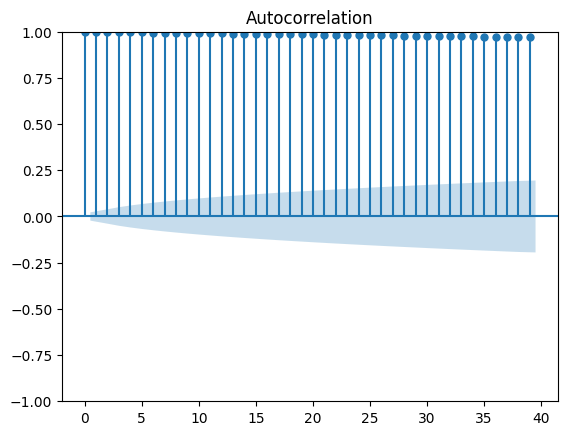

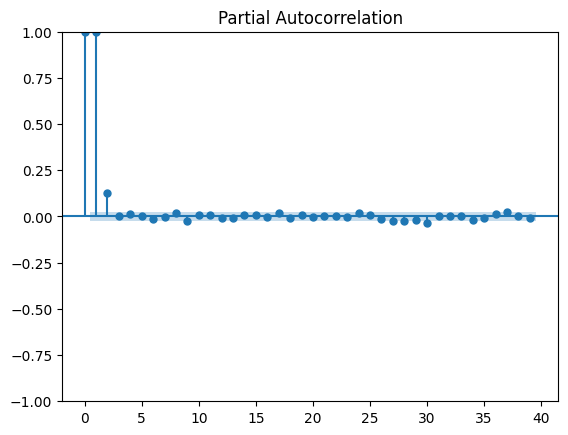

In [6]:
# Plot ACF and PACF to estimate p, q
plot_acf(df["USD_AUD"])
plt.show()

plot_pacf(df["USD_AUD"])
plt.show()

In [7]:
# Let's difference the data once (d=1)
diff_data = df["USD_AUD"].diff().dropna()

# Split into train and test
train = df.iloc[:-12]
test = df.iloc[-12:]


In [8]:
# Fit ARIMA
model_arima = ARIMA(train["USD_AUD"], order=(1, 1, 1))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

# Forecast
forecast_arima = model_arima_fit.forecast(steps=12)
forecast_arima.index = test.index

                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 7576
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28004.487
Date:                Mon, 14 Jul 2025   AIC                         -56002.974
Time:                        20:58:30   BIC                         -55982.177
Sample:                             0   HQIC                        -55995.836
                               - 7576                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1270      0.045     -2.798      0.005      -0.216      -0.038
ma.L1         -0.0045      0.046     -0.098      0.922      -0.094       0.085
sigma2      3.601e-05   9.97e-08    361.098      0.0

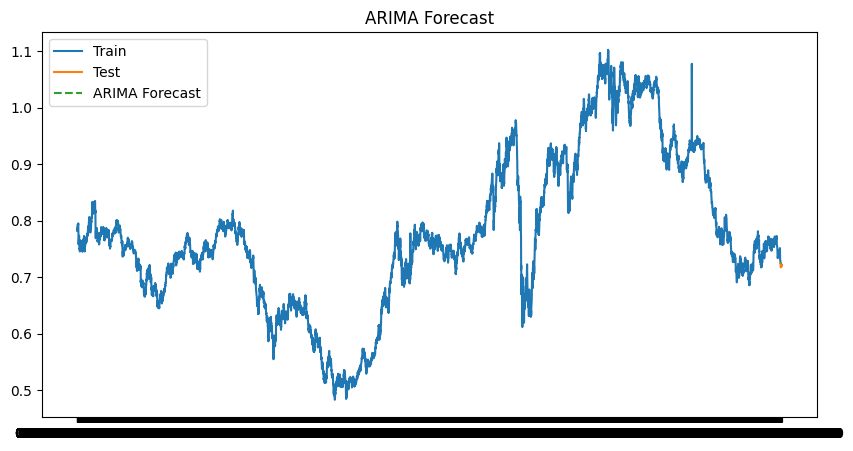

In [9]:
# Plot ARIMA forecast
plt.figure(figsize=(10, 5))
plt.plot(train.index, train["USD_AUD"], label="Train")
plt.plot(test.index, test["USD_AUD"], label="Test")
plt.plot(forecast_arima, label="ARIMA Forecast", linestyle="--")
plt.legend()
plt.title("ARIMA Forecast")
plt.show()

In [10]:

# -------------------------------
# PART 3: Exponential Smoothing
# -------------------------------

model_es = ExponentialSmoothing(
    train["USD_AUD"], trend="add", seasonal=None, seasonal_periods=None
).fit()

forecast_es = model_es.forecast(12)
forecast_es.index = test.index



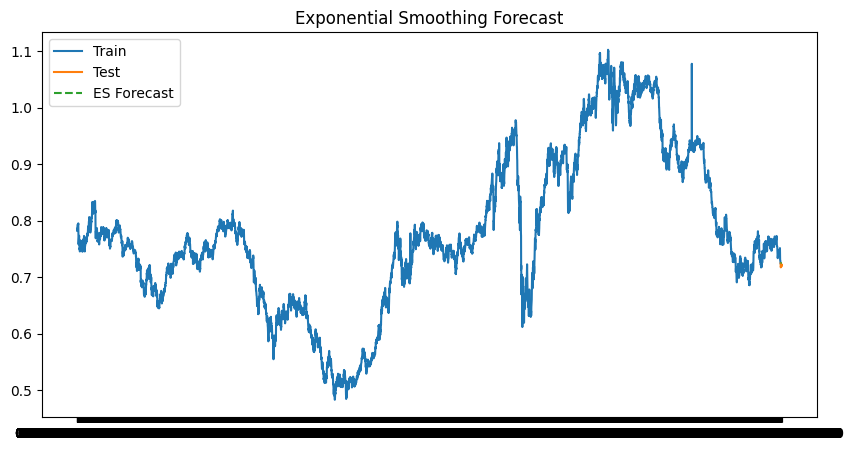

In [11]:
# Plot Exponential Smoothing forecast
plt.figure(figsize=(10, 5))
plt.plot(train.index, train["USD_AUD"], label="Train")
plt.plot(test.index, test["USD_AUD"], label="Test")
plt.plot(forecast_es, label="ES Forecast", linestyle="--")
plt.legend()
plt.title("Exponential Smoothing Forecast")
plt.show()


In [12]:
# -------------------------------
# PART 4: Evaluation
# -------------------------------

def evaluate(true, pred, label):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    print(f"\n{label} Performance:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

evaluate(test["USD_AUD"], forecast_arima, "ARIMA")
evaluate(test["USD_AUD"], forecast_es, "Exponential Smoothing")


ARIMA Performance:
MAE: 0.0048
RMSE: 0.0052
MAPE: 0.66%

Exponential Smoothing Performance:
MAE: 0.0048
RMSE: 0.0052
MAPE: 0.67%
